### Non linear equation : f1,f2 = x2+y2+z+1, x2+y+z2-1
### 3 dimensional input : 


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.manifold import TSNE

In [ ]:
bias_true = np.array([1,-1])
x = np.random.uniform(-1, 1, (100, 3))
weights_1 = np.array([[1, 1,0],[1,0,1]]).T
weights_2 = np.array([[0,0,1],[0,1,0]]).T

y_true = (x ** 2) @ weights_1 +  x @ weights_2 + bias_true

# dy/dx = 2*x*weights_true + weights_true
# dy/dw = x2 + x
# dy/db = 1
print(y_true.shape)
print((np.square(x).shape))
print(x)

(100, 2)
(100, 3)
[[ 0.90445965 -0.45985775  0.38902016]
 [ 0.23735562  0.08118612  0.17495587]
 [ 0.87568183  0.16307408 -0.85852027]
 [ 0.85995205 -0.47490815 -0.23564424]
 [ 0.80277698 -0.90827711  0.51287991]
 [ 0.26999273  0.35981104 -0.08964008]
 [-0.16918847  0.22785045 -0.41962467]
 [ 0.34057174  0.01080739 -0.19462709]
 [ 0.43194277 -0.76205723  0.3847606 ]
 [ 0.97031659  0.54043399 -0.05299168]
 [ 0.99170461 -0.04340732 -0.9722045 ]
 [ 0.96573089  0.15610558 -0.98718949]
 [ 0.85351034  0.84817548 -0.41771533]
 [ 0.03600433 -0.90879551  0.09375722]
 [ 0.11567111 -0.67629416 -0.69772563]
 [ 0.20729617 -0.9655518   0.25538943]
 [-0.59860949 -0.06747954  0.26839025]
 [-0.7501439  -0.22878885  0.84566984]
 [-0.59707565  0.04768852 -0.72006727]
 [ 0.7155003  -0.97369725  0.51810311]
 [ 0.71410094 -0.3933896   0.62293379]
 [ 0.87527532  0.07245964 -0.58858562]
 [ 0.64674524  0.41291022 -0.24167431]
 [-0.40351125 -0.84377806  0.93819045]
 [ 0.77720684  0.51353186 -0.43799457]
 [-0.70

## Plotting function

(100, 2)
(100, 2)


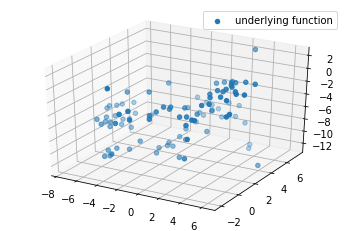

In [ ]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

X_embedded = TSNE(n_components=2).fit_transform(x)
y_embedded = TSNE(n_components=1).fit_transform(y_true)

print(X_embedded.shape)
print(y_true.shape)

plot_3d(X_embedded, y_embedded)

## Loss function and Linear layer

In [ ]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    #print('gradient shape',self.gradient.shape)
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
   # output = x @ self.weights + self.bias
    output = (x**2) @ self.weights + x @ self.weights + self.bias
    return output

  # x2 + x + 1
  # dy/dx = 2*x*weights_true + weights_true
  # dy/dw = x2 + x
  # dy/db = 1
  def backward(self, gradient):
    # self.weights_gradient = self.x.T @ gradient
    # self.bias_gradient = gradient.sum(axis=0)
    # self.x_gradient = gradient @ self.weights.T
    self.weights_gradient = (np.square(self.x) + self.x).T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T

    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

## Relu Layer

In [ ]:
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

## Defining model

(100, 2)
188.01324586332646


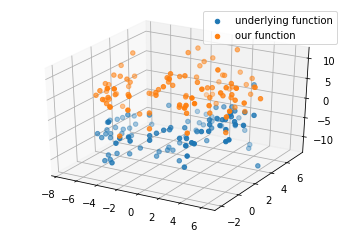

In [ ]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, 6)
    self.relu = Relu()
    self.linear2 = Linear(6, 4)
    self.relu2 = Relu()
    self.linear3 = Linear(4, 2)

  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    r2 = self.relu2(l2)
    l3 = self.linear3(r2)
    return l3
  
  def backward(self, output_gradient):

    linear3_gradient = self.linear3.backward(output_gradient)
    relu_gradient = self.relu2.backward(linear3_gradient)

    linear2_gradient = self.linear2.backward(relu_gradient)
    relu2_gradient = self.relu.backward(linear2_gradient)

    linear1_gradient = self.linear1.backward(relu2_gradient)
    #print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    return linear3_gradient

  def update(self, lr):
    self.linear3.update(lr)
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(3, 1)
y_pred = model(x)
print(y_pred.shape)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)

plot_3d(X_embedded, y_embedded,y_pred_embedded)

## Training function

In [ ]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

Epoch 0, loss 0.5336298420981145
Epoch 1, loss 0.5330749206784586
Epoch 2, loss 0.5325585976604841
Epoch 3, loss 0.5320780327074464
Epoch 4, loss 0.5316306038400436
Epoch 5, loss 0.5311979978154265
Epoch 6, loss 0.5307633766764969
Epoch 7, loss 0.5303570801762654
Epoch 8, loss 0.5299771338986291
Epoch 9, loss 0.529636077543153
Epoch 10, loss 0.5293406794250902
Epoch 11, loss 0.5290656108264064
Epoch 12, loss 0.5288093707813571
Epoch 13, loss 0.5285705727854757
Epoch 14, loss 0.5283479359115187
Epoch 15, loss 0.5281484895966854
Epoch 16, loss 0.5279811457736585
Epoch 17, loss 0.5278263682431632
Epoch 18, loss 0.5276831825259514
Epoch 19, loss 0.5275506905533242
Epoch 20, loss 0.5274280646487951
Epoch 21, loss 0.5273145419848094
Epoch 22, loss 0.5272153308609769
Epoch 23, loss 0.5271225800896923
Epoch 24, loss 0.5270371136235239
Epoch 25, loss 0.5269583593423972
Epoch 26, loss 0.5268857900599913
Epoch 27, loss 0.5268194027553448
Epoch 28, loss 0.526758642592645
Epoch 29, loss 0.526701773

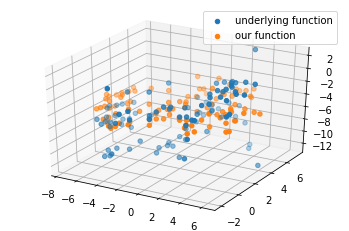

In [ ]:
fit(x, y_true, model=model, loss=loss, lr=0.02, num_epochs=70)
y_pred= model(x)
y_pred_embedded = TSNE(n_components=1).fit_transform(y_pred)
plot_3d(X_embedded, y_embedded,y_pred_embedded)